<a href="https://colab.research.google.com/github/NegiArvind/FaceRecognitionUsingTensorflow/blob/master/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Mounting the drive

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
!ls "/content/drive/My Drive/FaceRecognition"


#### Unzip the pretrained model of face recognition which is present inside FaceRecognition folder inside my drive

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('drive/My Drive/FaceRecognition/20180402-114759.zip', 'r')
zip_ref.extractall('drive/My Drive/FaceRecognition')
zip_ref.close()

####  Installing dlib library

In [0]:
!apt update
!apt install -y cmake
!pip install dlib

#### align_dlib.py
This script contain methods which are used to align the image


In [0]:
# -*- coding: utf-8 -*-

# Copyright 2015-2016 Carnegie Mellon University
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Module for dlib-based alignment."""

# NOTE: This file has been copied from the openface project.
# https://github.com/cmusatyalab/openface/blob/master/openface/align_dlib.py

import cv2
import dlib
import numpy as np

TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

INV_TEMPLATE = np.float32([
    (-0.04099179660567834, -0.008425234314031194, 2.575498465013183),
    (0.04062510634554352, -0.009678089746831375, -1.2534351452524177),
    (0.0003666902601348179, 0.01810332406086298, -0.32206331976076663)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)


class AlignDlib:
    """
    Use `dlib's landmark estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`_ to align faces.

    The alignment preprocess faces for input into a neural network.
    Faces are resized to the same size (such as 96x96) and transformed
    to make landmarks (such as the eyes and nose) appear at the same
    location on every image.

    Normalized landmarks:

    .. image:: ../images/dlib-landmark-mean.png
    """

    #: Landmark indices corresponding to the inner eyes and bottom lip.
    INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]

    #: Landmark indices corresponding to the outer eyes and nose.
    OUTER_EYES_AND_NOSE = [36, 45, 33]

    def __init__(self, facePredictor):
        """
        Instantiate an 'AlignDlib' object.

        :param facePredictor: The path to dlib's
        :type facePredictor: str
        """
        assert facePredictor is not None

        # pylint: disable=no-member
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(facePredictor)

    def getAllFaceBoundingBoxes(self, rgbImg):
        """
        Find all face bounding boxes in an image.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :return: All face bounding boxes in an image.
        :rtype: dlib.rectangles
        """
        assert rgbImg is not None

        try:
            return self.detector(rgbImg, 1)
        except Exception as e:  # pylint: disable=broad-except
            print("Warning: {}".format(e))
            # In rare cases, exceptions are thrown.
            return []

    def getLargestFaceBoundingBox(self, rgbImg, skipMulti=False):
        """
        Find the largest face bounding box in an image.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :return: The largest face bounding box in an image, or None.
        :rtype: dlib.rectangle
        """
        assert rgbImg is not None

        faces = self.getAllFaceBoundingBoxes(rgbImg)
        if (not skipMulti and len(faces) > 0) or len(faces) == 1:
            return max(faces, key=lambda rect: rect.width() * rect.height())
        else:
            return None

    def findLandmarks(self, rgbImg, bb):
        """
        Find the landmarks of a face.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to find landmarks for.
        :type bb: dlib.rectangle
        :return: Detected landmark locations.
        :rtype: list of (x,y) tuples
        """
        assert rgbImg is not None
        assert bb is not None

        points = self.predictor(rgbImg, bb)
        # return list(map(lambda p: (p.x, p.y), points.parts()))
        return [(p.x, p.y) for p in points.parts()]

    # pylint: disable=dangerous-default-value
    def align(self, imgDim, rgbImg, bb=None,
              landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP,
              skipMulti=False, scale=1.0):
        r"""align(imgDim, rgbImg, bb=None, landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP)

        Transform and align a face in an image.

        :param imgDim: The edge length in pixels of the square the image is resized to.
        :type imgDim: int
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to align. \
                   Defaults to the largest face.
        :type bb: dlib.rectangle
        :param landmarks: Detected landmark locations. \
                          Landmarks found on `bb` if not provided.
        :type landmarks: list of (x,y) tuples
        :param landmarkIndices: The indices to transform to.
        :type landmarkIndices: list of ints
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :param scale: Scale image before cropping to the size given by imgDim.
        :type scale: float
        :return: The aligned RGB image. Shape: (imgDim, imgDim, 3)
        :rtype: numpy.ndarray
        """
        assert imgDim is not None
        assert rgbImg is not None
        assert landmarkIndices is not None

        if bb is None:
            bb = self.getLargestFaceBoundingBox(rgbImg, skipMulti)
            if bb is None:
                return

        if landmarks is None:
            landmarks = self.findLandmarks(rgbImg, bb)

        npLandmarks = np.float32(landmarks)
        npLandmarkIndices = np.array(landmarkIndices)

        # pylint: disable=maybe-no-member
        H = cv2.getAffineTransform(npLandmarks[npLandmarkIndices],
                                   imgDim * MINMAX_TEMPLATE[npLandmarkIndices] * scale + imgDim * (1 - scale) / 2)
        thumbnail = cv2.warpAffine(rgbImg, H, (imgDim, imgDim))

        return thumbnail


####  find_faces_and_preprocessing.py
This script will process the image, align them and then save the aligned image in the folder


In [5]:
import dlib
import cv2
#from align_dlib import AlignDlib # This is python file saved in this working directory
import os
driveLocation='drive/My Drive/FaceRecognition'
imageLocation=driveLocation+'/dataset/input'
imageOutputLocation=driveLocation+"/dataset/AlignedOutput"
# we can download the required pre-trained face detection model here:
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_model=driveLocation+"/shape_predictor_68_face_landmarks.dat"
face_aligner=None
face_detector=None

# Either we can use below method to load image or io.imread(imageLocation) to read method

# img=image.load_img(imageLocation)
# img=np.uint8(img) # it will convert Image type into uint8 type


#img = io.imread(imageLocation)
def preprocess(imageLocation,imageOutputLocation):
    
    if not os.path.exists(imageOutputLocation):
        os.makedirs(imageOutputLocation)
    for input_dir in os.listdir(imageLocation):
        image_output_dir=os.path.join(imageOutputLocation,input_dir)
        if not os.path.exists(image_output_dir):
            os.makedirs(image_output_dir)
        image_input_class_dir=os.path.join(imageLocation,input_dir)
        for i,image_name in enumerate(os.listdir(image_input_class_dir)):
            newImageName=input_dir+str(i+1)+".jpg"
            os.rename(image_input_class_dir+"/"+image_name,image_input_class_dir+"/"+newImageName)
            detect_and_align_faces(os.path.join(image_input_class_dir,newImageName),os.path.join(image_output_dir,newImageName))
    

def initialize():
    global face_aligner
    global face_detector
    # Create a HOG Face detector using built indlib class
    face_detector=dlib.get_frontal_face_detector()
    #  To deal with the problem that faces turned different directions look totally different to a computer:
    # we use face_pose_predictor package to deal with it
    # We uses face_landmark estimation algorithm (68 specific points)
    # face_pose_predictor=dlib.shape_predictor(predictor_model)
    # To align the image we need to make an object of AlignDlib class
    face_aligner=AlignDlib(predictor_model)

    

# win=dlib.image_window() # it will open a new window to show the image

def detect_and_align_faces(imageInputLocation,imageOutputLocation):
    
    print("detect "+imageInputLocation+" "+imageOutputLocation)
    img = cv2.imread(imageInputLocation)
    # Run the HOG face detector on the image data.
    # The result will be the bounding boxes of the faces in our image.
    detected_faces = face_detector(img, 1)
    
    print("I found {} faces in the file {}".format(len(detected_faces), imageInputLocation))
    
    # Open a window on the desktop showing the image
    #win.set_image(img)
    
    #Loop through each face we found in our image
    for i,face_rect in enumerate(detected_faces):
        # Detected faces are returned as an object with the coordinates of the top, left, right and bottom edges
        print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".
              format(i+1, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()))
        # Draw a box around each face we found
        # win.add_overlay(face_rect)
        
        # Get the the face's pose
        # pose_landmarks = face_pose_predictor(img, face_rect)
        # Aligning the face in correct position.
        alignedFace=face_aligner.align(imgDim=234,rgbImg=img,bb=face_rect,
                                       landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
        # imgDim = The edge length in pixels of the square the image is resized to
        
        #Draw the face landmarks on the image
        # win.add_overlay(pose_landmarks)
        
        # Save the aligned image to a file
        cv2.imwrite(imageOutputLocation, alignedFace)

# Wait until the user hits <enter> to close the window
# dlib.hit_enter_to_continue()

if __name__=="__main__":
    initialize()
    preprocess(imageLocation,imageOutputLocation)


detect drive/My Drive/FaceRecognition/dataset/input/nupur/nupur1.jpg drive/My Drive/FaceRecognition/dataset/AlignedOutput/nupur/nupur1.jpg
I found 1 faces in the file drive/My Drive/FaceRecognition/dataset/input/nupur/nupur1.jpg
- Face #1 found at Left: 204 Top: 33 Right: 589 Bottom: 418
detect drive/My Drive/FaceRecognition/dataset/input/nupur/nupur2.jpg drive/My Drive/FaceRecognition/dataset/AlignedOutput/nupur/nupur2.jpg
I found 1 faces in the file drive/My Drive/FaceRecognition/dataset/input/nupur/nupur2.jpg
- Face #1 found at Left: 118 Top: 162 Right: 504 Bottom: 547
detect drive/My Drive/FaceRecognition/dataset/input/nupur/nupur3.jpg drive/My Drive/FaceRecognition/dataset/AlignedOutput/nupur/nupur3.jpg
I found 1 faces in the file drive/My Drive/FaceRecognition/dataset/input/nupur/nupur3.jpg
- Face #1 found at Left: 612 Top: 268 Right: 741 Bottom: 397
detect drive/My Drive/FaceRecognition/dataset/input/nupur/nupur4.jpg drive/My Drive/FaceRecognition/dataset/AlignedOutput/nupur/nup

#### lfw_input.py

This script contains all the method which are used to get the dataset,split them and convert them into training and test set.

In [0]:
# -*- coding: utf-8 -*-

import logging
import os

import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops

logger = logging.getLogger(__name__)


def read_data(image_paths, label_list, image_size, batch_size, max_nrof_epochs, num_threads, shuffle, random_flip,
              random_brightness, random_contrast):
    """
    Creates Tensorflow Queue to batch load images. Applies transformations to images as they are loaded.
    :param random_brightness: 
    :param random_flip: 
    :param image_paths: image paths to load
    :param label_list: class labels for image paths
    :param image_size: size to resize images to
    :param batch_size: num of images to load in batch
    :param max_nrof_epochs: total number of epochs to read through image list
    :param num_threads: num threads to use
    :param shuffle: Shuffle images
    :param random_flip: Random Flip image
    :param random_brightness: Apply random brightness transform to image
    :param random_contrast: Apply random contrast transform to image
    :return: images and labels of batch_size
    """

    images = ops.convert_to_tensor(image_paths, dtype=tf.string)
    labels = ops.convert_to_tensor(label_list, dtype=tf.int32)

    # Makes an input queue
    input_queue = tf.train.slice_input_producer((images, labels),
                                                num_epochs=max_nrof_epochs, shuffle=shuffle, )

    images_labels = []
    imgs = []
    lbls = []
    for _ in range(num_threads):
        image, label = read_image_from_disk(filename_to_label_tuple=input_queue)
        image = tf.random_crop(image, size=[image_size, image_size, 3])
        image.set_shape((image_size, image_size, 3))
        image = tf.image.per_image_standardization(image)

        if random_flip:
            image = tf.image.random_flip_left_right(image)

        if random_brightness:
            image = tf.image.random_brightness(image, max_delta=0.3)

        if random_contrast:
            image = tf.image.random_contrast(image, lower=0.2, upper=1.8)

        imgs.append(image)
        lbls.append(label)
        images_labels.append([image, label])

    image_batch, label_batch = tf.train.batch_join(images_labels,
                                                   batch_size=batch_size,
                                                   capacity=4 * num_threads,
                                                   enqueue_many=False,
                                                   allow_smaller_final_batch=True)
    return image_batch, label_batch


def read_image_from_disk(filename_to_label_tuple):
    """
    Consumes input tensor and loads image
    :param filename_to_label_tuple: 
    :type filename_to_label_tuple: list
    :return: tuple of image and label
    """
    label = filename_to_label_tuple[1]
    file_contents = tf.read_file(filename_to_label_tuple[0])
    example = tf.image.decode_jpeg(file_contents, channels=3)
    return example, label


def get_image_paths_and_labels(dataset):
    image_paths_flat = []
    labels_flat = []
    for i in range(int(len(dataset))):
        image_paths_flat += dataset[i].image_paths
        labels_flat += [i] * len(dataset[i].image_paths)
    return image_paths_flat, labels_flat


def get_dataset(input_directory):
    dataset = []

    classes = os.listdir(input_directory)
    classes.sort()
    nrof_classes = len(classes)
    for i in range(nrof_classes):
        class_name = classes[i]
        facedir = os.path.join(input_directory, class_name)
        if os.path.isdir(facedir):
            images = os.listdir(facedir)
            image_paths = [os.path.join(facedir, img) for img in images]
            dataset.append(ImageClass(class_name, image_paths))

    return dataset


def filter_dataset(dataset, min_images_per_label=10):
    filtered_dataset = []
    for i in range(len(dataset)):
        if len(dataset[i].image_paths) < min_images_per_label:
            logger.info('Skipping class: {}'.format(dataset[i].name))
            continue
        else:
            filtered_dataset.append(dataset[i])
    return filtered_dataset


def split_dataset(dataset, split_ratio=0.8):
    train_set = []
    test_set = []
    min_nrof_images = 2
    for cls in dataset:
        paths = cls.image_paths
        np.random.shuffle(paths)
        split = int(round(len(paths) * split_ratio))
        if split < min_nrof_images:
            continue  # Not enough images for test set. Skip class...
        train_set.append(ImageClass(cls.name, paths[0:split]))
        test_set.append(ImageClass(cls.name, paths[split:-1]))
    return train_set, test_set


class ImageClass():
    def __init__(self, name, image_paths):
        self.name = name
        self.image_paths = image_paths

    def __str__(self):
        return self.name + ', ' + str(len(self.image_paths)) + ' images'

    def __len__(self):
        return len(self.image_paths)


#### train_the_model.py
This script is used to train and test the dataset using pretrained model and then classify them


In [18]:
# -*- coding: utf-8 -*-

import argparse
import logging
import os
import pickle
import sys
import time

import numpy as np
import tensorflow as tf
from sklearn.svm import SVC
from tensorflow.python.platform import gfile
from tensorflow.python.framework import ops

# from lfw_input import filter_dataset, split_dataset, get_dataset
# import lfw_input

logger = logging.getLogger(__name__)
driveLocation="drive/My Drive/FaceRecognition"


def read_data(image_paths, label_list, image_size, batch_size, max_nrof_epochs, num_threads, shuffle, random_flip,
              random_brightness, random_contrast):
  
    # it mixes images and labels when creating batches.Also it added transformation images.
    
    """
    Creates Tensorflow Queue to batch load images. Applies transformations to images as they are loaded.
    :param random_brightness: 
    :param random_flip: 
    :param image_paths: image paths to load
    :param label_list: class labels for image paths
    :param image_size: size to resize images to
    :param batch_size: num of images to load in batch
    :param max_nrof_epochs: total number of epochs to read through image list
    :param num_threads: num threads to use
    :param shuffle: Shuffle images
    :param random_flip: Random Flip image
    :param random_brightness: Apply random brightness transform to image
    :param random_contrast: Apply random contrast transform to image
    :return: images and labels of batch_size
    """

    # Converting arrays into tensor using ops package of tensorflow
    images = ops.convert_to_tensor(image_paths, dtype=tf.string) 
    labels = ops.convert_to_tensor(label_list, dtype=tf.int32)

    # getting tensor slices
    input_queue = tf.train.slice_input_producer((images, labels),
                                                num_epochs=max_nrof_epochs, shuffle=shuffle, )

    images_labels = []
    imgs = []
    lbls = []
    for _ in range(num_threads):
        image, label = read_image_from_disk(filename_to_label_tuple=input_queue)
        image = tf.random_crop(image, size=[image_size, image_size, 3])
        image.set_shape((image_size, image_size, 3))
        image = tf.image.per_image_standardization(image)

        if random_flip:
            image = tf.image.random_flip_left_right(image)

        if random_brightness:
            image = tf.image.random_brightness(image, max_delta=0.3)

        if random_contrast:
            image = tf.image.random_contrast(image, lower=0.2, upper=1.8)

        imgs.append(image)
        lbls.append(label)
        images_labels.append([image, label])

    print("Lots of images after applying rotation,shearing etc")
    print(imgs)
    print(len(imgs))
    image_batch, label_batch = tf.train.batch_join(images_labels,
                                                   batch_size=batch_size,
                                                   capacity=4 * num_threads,
                                                   enqueue_many=False,
                                                   allow_smaller_final_batch=True)
    return image_batch, label_batch


def read_image_from_disk(filename_to_label_tuple):
    """
    Consumes input tensor and loads image
    :param filename_to_label_tuple: 
    :type filename_to_label_tuple: list
    :return: tuple of image and label
    """
    # filename_to_label_tuple is 2D arraylist. First column contain image_path and 2nd column contains
    # its corresponding labels.
    label = filename_to_label_tuple[1]
    file_contents = tf.read_file(filename_to_label_tuple[0]) # reading the files from image_paths array(filename_to_label_tuple[0])
    example = tf.image.decode_jpeg(file_contents, channels=3)
    return example, label


def get_image_paths_and_labels(dataset):
    image_paths_flat = []
    labels_flat = []
    for i in range(int(len(dataset))):
        image_paths_flat += dataset[i].image_paths
        labels_flat += [i] * len(dataset[i].image_paths) #set the label(0,1,2,..) to each image
    return image_paths_flat, labels_flat


def get_dataset(input_directory):
    dataset = []

    classes = os.listdir(input_directory)
    classes.sort()
    nrof_classes = len(classes)
    for i in range(nrof_classes):
        class_name = classes[i]
        facedir = os.path.join(input_directory, class_name)
        if os.path.isdir(facedir):
            images = os.listdir(facedir)
            image_paths = [os.path.join(facedir, img) for img in images]
            dataset.append(ImageClass(class_name, image_paths))

    print("Dataset")
    print(dataset)
    return dataset


def filter_dataset(dataset, min_images_per_label=10):
    filtered_dataset = []
    for i in range(len(dataset)):
        if len(dataset[i].image_paths) < min_images_per_label:
            print('Skipping class: {}'.format(dataset[i].name))
            logger.info('Skipping class: {}'.format(dataset[i].name))
            continue
        else:
            filtered_dataset.append(dataset[i])
    return filtered_dataset


def split_dataset(dataset, split_ratio=0.8):
  
    print("inside split dataset")
    train_set = []
    test_set = []
    min_nrof_images = 2
    for cls in dataset:
        paths = cls.image_paths
        np.random.shuffle(paths)
        split = int(round(len(paths) * split_ratio))
        if split < min_nrof_images:
            continue  # Not enough images for test set. Skip class...
        train_set.append(ImageClass(cls.name, paths[0:split]))
        test_set.append(ImageClass(cls.name, paths[split:-1]))
    
    print("trainset ")
    print(train_set)
    print("testset ")
    print(test_set)
    return train_set, test_set



def main(input_directory, model_path, classifier_output_path, batch_size, num_threads, num_epochs,
         min_num_images_per_class, split_ratio, is_train):
    """
    Loads images from :param input_dir, creates embeddings using a model defined at :param model_path, and trains
     a classifier outputted to :param output_path
     
    :param input_directory: Path to directory containing pre-processed images
    :param model_path: Path to protobuf graph file for facenet model
    :param classifier_output_path: Path to write pickled classifier
    :param batch_size: Batch size to create embeddings
    :param num_threads: Number of threads to utilize for queuing
    :param num_epochs: Number of epochs for each image
    :param min_images_per_labels: Minimum number of images per class
    :param split_ratio: Ratio to split train/test dataset
    :param is_train: bool denoting if training or evaluate
    """

    start_time = time.time()
    with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
        train_set, test_set = _get_test_and_train_set(input_directory, min_num_images_per_label=min_num_images_per_class,
                                                      split_ratio=split_ratio)
        if is_train:
            images, labels, class_names = _load_images_and_labels(train_set, image_size=160, batch_size=batch_size,
                                                                  num_threads=num_threads, num_epochs=num_epochs,
                                                                  random_flip=True, random_brightness=True,
                                                                  random_contrast=True)
        else:
            images, labels, class_names = _load_images_and_labels(test_set, image_size=160, batch_size=batch_size,
                                                                  num_threads=num_threads, num_epochs=1)

        print("images: ")
        print(images)
        print("labels: ")
        print(labels)
        print("class_names: ")
        print(class_names)
        _load_model(model_filepath=model_path)

        # tf.group_variable_initializer() is a method to intialize all tensor global vaariable
        # tf.local_variable_initializer() is a method to intialize all tensor local vaariable
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)

        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embedding_layer = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord, sess=sess)

        emb_array, label_array = _create_embeddings(embedding_layer, images, labels, images_placeholder,
                                                    phase_train_placeholder, sess)

        coord.request_stop()
        coord.join(threads=threads)
        print('Created {} embeddings'.format(len(emb_array)))

        classifier_filename = classifier_output_path

        if is_train:
            _train_and_save_classifier(emb_array, label_array, class_names, classifier_filename)
        else:
            _evaluate_classifier(emb_array, label_array, classifier_filename)

        print('Completed in {} seconds'.format(time.time() - start_time))
        logger.info('Completed in {} seconds'.format(time.time() - start_time))


def _get_test_and_train_set(input_dir, min_num_images_per_label, split_ratio=0.7):
    """
    Load train and test dataset. Classes with < :param min_num_images_per_label will be filtered out.
    :param input_dir: 
    :param min_num_images_per_label: 
    :param split_ratio: 
    :return: 
    """
    dataset = get_dataset(input_dir)
    dataset = filter_dataset(dataset, min_images_per_label=min_num_images_per_label)
    train_set, test_set = split_dataset(dataset, split_ratio=split_ratio)
    for cls in test_set:
      print(cls.name)
      print(cls.image_paths)
#     print("train set "+ train_set)
#     print("test_set "+test_set)
    return train_set, test_set


def _load_images_and_labels(dataset, image_size, batch_size, num_threads, num_epochs, random_flip=False,
                            random_brightness=False, random_contrast=False):
    class_names = [cls.name for cls in dataset]
    
#     image_paths, labels = lfw_input.get_image_paths_and_labels(dataset)
#     images, labels = lfw_input.read_data(image_paths, labels, image_size, batch_size, num_epochs, num_threads,
#                                          shuffle=False, random_flip=random_flip, random_brightness=random_brightness,
#                                          random_contrast=random_contrast)
    
    image_paths, labels = get_image_paths_and_labels(dataset)
    images, labels = read_data(image_paths, labels, image_size, batch_size, num_epochs, num_threads,
                                         shuffle=False, random_flip=random_flip, random_brightness=random_brightness,
                                         random_contrast=random_contrast)
    return images, labels, class_names


def _load_model(model_filepath):
    """
    Load frozen protobuf graph
    :param model_filepath: Path to protobuf graph
    :type model_filepath: str
    """
    
    model_exp = os.path.expanduser(model_filepath)
    if os.path.isfile(model_exp):
        logging.info('Model filename: %s' % model_exp)
        with gfile.FastGFile(model_exp, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
    else:
        print('Missing model file. Exiting')
        sys.exit(-1)


def _create_embeddings(embedding_layer, images, labels, images_placeholder, phase_train_placeholder, sess):
    
    """
    Uses model to generate embeddings from :param images.
    :param embedding_layer: 
    :param images: - images for which you have to create embedding(128 decimal output)
    :param labels: -labels of images
    :param images_placeholder: 
    :param phase_train_placeholder: 
    :param sess: 
    :return: (tuple): image embeddings and labels
    """
    
    emb_array = None
    label_array = None
    try:
        i = 0
        while True:
            batch_images, batch_labels = sess.run([images, labels])
            print('Processing iteration {} batch of size: {}'.format(i, len(batch_labels)))
            emb = sess.run(embedding_layer,
                           feed_dict={images_placeholder: batch_images, phase_train_placeholder: False})

            print("emb")
            print(emb)
            emb_array = np.concatenate([emb_array, emb]) if emb_array is not None else emb
            label_array = np.concatenate([label_array, batch_labels]) if label_array is not None else batch_labels
            i += 1

    except tf.errors.OutOfRangeError:
        pass
    print(emb_array)
    print(label_array)

    return emb_array, label_array


def _train_and_save_classifier(emb_array, label_array, class_names, classifier_filename_exp):
    print('Training Classifier')
    model = SVC(kernel='linear', probability=True, verbose=False)
    model.fit(emb_array, label_array)

    with open(classifier_filename_exp, 'wb') as outfile:
        pickle.dump((model, class_names), outfile)
    print('Saved classifier model to file "%s"' % classifier_filename_exp)


def _evaluate_classifier(emb_array, label_array, classifier_filename):
    print('Evaluating classifier on {} images'.format(len(emb_array)))
    if not os.path.exists(classifier_filename):
        raise ValueError('Pickled classifier not found, have you trained first?')

    with open(classifier_filename, 'rb') as f:
        model, class_names = pickle.load(f)
        
        print("class names ")
        print(class_names)

        predictions = model.predict_proba(emb_array, )
        
        print("predictions")
        print(predictions)
        
        best_class_indices = np.argmax(predictions, axis=1) #argmax is used to get the index of maximum value 
        # in 2d array along axis=1(row). means in each row, which is the index having maximum value  
        
        best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]

        for i in range(len(best_class_indices)):
            print('%4d  %s: %.3f' % (i, class_names[best_class_indices[i]], best_class_probabilities[i]))

        print("predicted best class indices")
        print(best_class_indices)
        accuracy = np.mean(np.equal(best_class_indices, label_array))
        print('Accuracy: %.3f' % accuracy)


if __name__ == '__main__':
    main(input_directory=driveLocation+'/dataset/AlignedOutput', model_path=driveLocation+"/20180402-114759/20180402-114759.pb"
         ,classifier_output_path=driveLocation+'/classifier.pkl',batch_size=1, num_threads=16
         , num_epochs=25,min_num_images_per_class=5, split_ratio=0.8, is_train=False) #For training the datset make it true and
    # for testing make it false


Dataset
[<__main__.ImageClass object at 0x7fbcd25d9198>, <__main__.ImageClass object at 0x7fbcd25d91d0>, <__main__.ImageClass object at 0x7fbcd25d9160>, <__main__.ImageClass object at 0x7fbcd25d9240>, <__main__.ImageClass object at 0x7fbcd25d9278>, <__main__.ImageClass object at 0x7fbcd25d9208>, <__main__.ImageClass object at 0x7fbcd25d92e8>, <__main__.ImageClass object at 0x7fbcd25d9320>]
inside split dataset
trainset 
[<__main__.ImageClass object at 0x7fbcd50a7f60>, <__main__.ImageClass object at 0x7fbcd25d9400>, <__main__.ImageClass object at 0x7fbcd25d92b0>, <__main__.ImageClass object at 0x7fbcd25d94e0>, <__main__.ImageClass object at 0x7fbcd25d9588>, <__main__.ImageClass object at 0x7fbcd25d95f8>, <__main__.ImageClass object at 0x7fbcd25d9668>, <__main__.ImageClass object at 0x7fbcd25d96d8>]
testset 
[<__main__.ImageClass object at 0x7fbcd25d93c8>, <__main__.ImageClass object at 0x7fbcd25d9390>, <__main__.ImageClass object at 0x7fbcd25d9358>, <__main__.ImageClass object at 0x7fbc

####  predict_the_face.py
This script wil predict the person in an image.
Basically first it will load the image from the storage and then extract the face image and align it.
After aligning this image will go for cnn.
But before cnn we have to resize and reshape this image(in the form of matrix)
After getting embedding value for predicting image we will classify it with our svm classiier.
As we have saved the trained classifier in the storage. So i will classify it by loading the classifier from the storage.

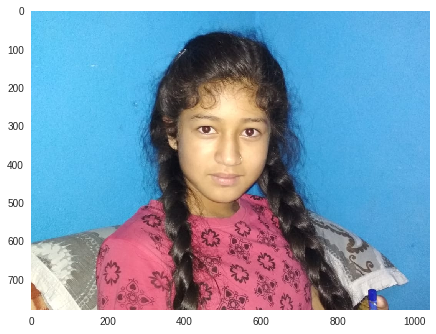

I found 1 faces in the file drive/My Drive/FaceRecognition/images/image9.jpeg
- Face #1 found at Left: 379 Top: 231 Right: 646 Bottom: 498
Model filename: drive/My Drive/FaceRecognition/20180402-114759/20180402-114759.pb
Model loaded successfully
Start creating embedding
Created 1 embeddings
class_names
['amit', 'anisha', 'arvind', 'avantika', 'katu', 'nupur', 'priya', 'ranju']
predictions
[[1.25849816e-03 1.97211857e-02 1.65856150e-03 8.23532790e-05
  1.33606892e-03 1.92570298e-04 9.75613708e-01 1.37053937e-04]]
best_class_indices
[6]
Prediction Result: 
   0  priya: 0.976


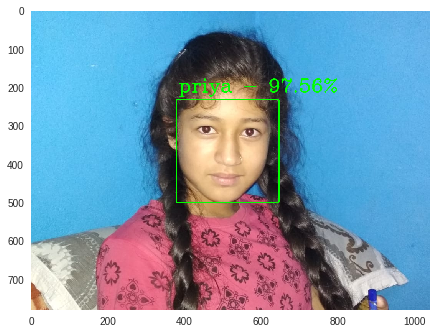

Completed in 8.753411769866943 seconds


In [21]:
# -*- coding: utf-8 -*-

# This script is used to predict the person in an image 

import cv2
import dlib
import time
import tensorflow as tf
import pickle
import os
import numpy as np
from tensorflow.python.platform import gfile
from matplotlib import pyplot as plt


# for drive
driveLocation='drive/My Drive/FaceRecognition/'
# for pc
# driveLocation=''
predictor_model=driveLocation+"shape_predictor_68_face_landmarks.dat"


def main(imageLocation, model_path, classifier_output_path):
    """
    Loads images from :param input_dir, creates embeddings using a model defined at :param model_path, and trains
     a classifier outputted to :param output_path
     
    :param input_directory: Path to directory containing pre-processed images
    :param model_path: Path to protobuf graph file for facenet model
    :param classifier_output_path: Path to write pickled classifier
    :param batch_size: Batch size to create embeddings
    :param num_threads: Number of threads to utilize for queuing
    :param num_epochs: Number of epochs for each image
    :param min_images_per_labels: Minimum number of images per class
    :param split_ratio: Ratio to split train/test dataset
    :param is_train: bool denoting if training or evaluate
    """

    img = cv2.imread(imageLocation)
    img=np.uint8(img)
    img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.rcParams["axes.grid"] = False #remove whitelines from the image
    plt.imshow(img_cvt)
    plt.show()
    
    start_time = time.time()
    with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
        
        aligned_images,boundary_boxes=detect_and_align_faces(imageLocation) # contains list of aligned face
        
        imgs=[]
        for image in aligned_images:
            #print("image size,"+str(image.shape))
            image=prewhiten(image) # it whitens the image
            resize_image=cv2.resize(image,(160,160),interpolation=cv2.INTER_CUBIC) # reshape image 3d matrix(234,234,3)
            # into (160,160,3)
            resize_image=resize_image.reshape(-1,160,160,3)
            imgs.append(resize_image)
            #print("image after resize,"+str(resize_image.shape))
            
            
#         print(imgs)
        
        _load_model(model_filepath=model_path)

        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)

        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embedding_layer = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

        emb_array =_create_embeddings(embedding_layer, imgs,images_placeholder,
                                                    phase_train_placeholder, sess)

        print('Created {} embeddings'.format(len(emb_array)))

        classifier_filename = classifier_output_path
        recognize_face(emb_array,classifier_filename,imageLocation,boundary_boxes)
        print('Completed in {} seconds'.format(time.time() - start_time))


def _create_embeddings(embedding_layer, images,images_placeholder, phase_train_placeholder, sess):
    
    """
    Uses model to generate embeddings from :param images.
    :param embedding_layer: 
    :param images: - images for which you have to create embedding(128 decimal output)
    :param labels: -labels of images
    :param images_placeholder: 
    :param phase_train_placeholder: 
    :param sess: 
    :return: (tuple): image embeddings and labels
    """
    print("Start creating embedding")
    emb_array = None
    try:
      for i in range(len(images)):
          emb = sess.run(embedding_layer,
                             feed_dict={images_placeholder: images[i], phase_train_placeholder: False})

#           print("emb")
#           print(emb)
          emb_array = np.concatenate([emb_array, emb]) if emb_array is not None else emb

#     try:
#         i = 0
#         while True:
#             emb = sess.run(embedding_layer,
#                            feed_dict={images_placeholder: images, phase_train_placeholder: False})

#             print("emb")
#             print(emb)
#             emb_array = np.concatenate([emb_array, emb]) if emb_array is not None else emb
#             i += 1
    except tf.errors.OutOfRangeError:
        pass

    
#     print(emb_array)
    return emb_array

def detect_and_align_faces(imageLocation):
    face_aligner=AlignDlib(predictor_model)
    face_detector=dlib.get_frontal_face_detector()
    img = cv2.imread(imageLocation)
    # Run the HOG face detector on the image data.
    # The result will be the bounding boxes of the faces in our image.
    detected_faces = face_detector(img, 1)
    
    print("I found {} faces in the file {}".format(len(detected_faces), imageLocation))
        
    aligned_faces=[]
    boundary_boxes=[]
    #Loop through each face we found in our image
    for i,face_rect in enumerate(detected_faces):
        # Detected faces are returned as an object with the coordinates of the top, left, right and bottom edges
        print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".
              format(i+1, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()))
        # Aligning the face in correct position.
        alignedFace=face_aligner.align(imgDim=234,rgbImg=img,bb=face_rect,
                                       landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
        aligned_faces.append(alignedFace)
        boundary_boxes.append(face_rect)
    
    return aligned_faces,boundary_boxes

def recognize_face(emb_array,classifier_filename,imageLocation,boundary_boxes):
    
    
    if not os.path.exists(classifier_filename):
        raise ValueError('Pickled classifier not found, have you trained first?')
    
    with open(classifier_filename,'rb') as f:
        
        model,class_names=pickle.load(f)
        print("class_names")
        print(class_names)
        predictions=model.predict_proba(emb_array,)
        print("predictions")
        print(predictions)
        best_class_indices = np.argmax(predictions, axis=1)
        
        print("best_class_indices")
        print(best_class_indices)
        best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
        
        print("Prediction Result: ")
        person_names=[]
        for i in range(len(best_class_indices)):
            person_name=''
            if best_class_probabilities[i]>0.52:
                 person_name=class_names[best_class_indices[i]]
            else:
                 person_name='Unknown'
            person_names.append(person_name)
            print('%4d  %s: %.3f' % (i,person_name, best_class_probabilities[i]))
        showPhoto(person_names,best_class_probabilities,capturedImage,boundary_boxes)    
        

def showPhoto(person_names,best_class_probabilities,image,boundary_boxes):
    image=np.uint8(image)
    for i in range(len(best_class_probabilities)):
        face_rect=boundary_boxes[i]
        person_name=person_names[i]
        image=cv2.rectangle(image,(face_rect.left(), face_rect.top()), (face_rect.right(), face_rect.bottom()),
                  (0,255,0),2) #(0,255,0) is the combination of color
        text_x=face_rect.left()+5
        text_y=face_rect.top()-20
        image=cv2.putText(image,person_name+" - "+str('%.2f'%(best_class_probabilities[i]*100))+"%",(text_x, text_y), cv2.FONT_HERSHEY_COMPLEX,
                0.6, (0, 255,0), thickness=1, lineType=cv2.LINE_AA)
#     cv2.imshow('image',image)
#     cv2.waitkey(0)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.rcParams["axes.grid"] = False #remove whitelines from the image
    plt.imshow(image)
    plt.show()
#     key_pressesd=cv2.waitkey(1)
#     if key_pressed==13 or key_pressed==32: #unicode for enter key and space key
#         cv2.destroyAllWindows()
        
    
def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y
  
def _load_model(model_filepath):
    """
    Load frozen protobuf graph
    :param model_filepath: Path to protobuf graph
    :type model_filepath: str
    """
    
    model_exp = os.path.expanduser(model_filepath)
    if os.path.isfile(model_exp):
        print('Model filename: %s' % model_exp)
        with gfile.FastGFile(model_exp, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
    else:
        print('Missing model file. Exiting')
        sys.exit(-1)
    print("Model loaded successfully")


if __name__=='__main__':
    
    main(imageLocation=driveLocation+'images/image9.jpeg',
         model_path=driveLocation+'20180402-114759/20180402-114759.pb',
         classifier_output_path=driveLocation+'classifier.pkl')

####  predict_from_video.py
This script will predict people from the video.

In [0]:
# -*- coding: utf-8 -*-

# This script is used to predict the person in an image 

import cv2
import dlib
import time
import tensorflow as tf
import pickle
import os
import numpy as np
from tensorflow.python.platform import gfile
from matplotlib import pyplot as plt
from align_dlib import AlignDlib

# for drive
driveLocation='drive/My Drive/FaceRecognition/'
# for pc
# driveLocation=''
predictor_model=driveLocation+"shape_predictor_68_face_landmarks.dat"


def main(videoLocation, model_path, classifier_output_path):
    """
    Loads images from :param input_dir, creates embeddings using a model defined at :param model_path, and trains
     a classifier outputted to :param output_path
     
    :param input_directory: Path to directory containing pre-processed images
    :param model_path: Path to protobuf graph file for facenet model
    :param classifier_output_path: Path to write pickled classifier
    :param batch_size: Batch size to create embeddings
    :param num_threads: Number of threads to utilize for queuing
    :param num_epochs: Number of epochs for each image
    :param min_images_per_labels: Minimum number of images per class
    :param split_ratio: Ratio to split train/test dataset
    :param is_train: bool denoting if training or evaluate
    """

#     img = cv2.imread(imageLocation)
#     img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.rcParams["axes.grid"] = False #remove whitelines from the image
#     plt.imshow(img_cvt)
#     plt.show()
    
    start_time = time.time()
    with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
        
        video_capture=cv2.VideoCapture(videoLocation)
        while video_capture.isOpened():
            ret,frame=video_capture.read()
            
            index = video_capture.get(cv2.CAP_PROP_POS_FRAMES)
            if (index % 60 == 0):
                print(index)
                #img_cvt=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                plt.rcParams["axes.grid"] = False #remove whitelines from the image
                plt.imshow(img_cvt)
                plt.show()
                aligned_images,boundary_boxes=detect_and_align_faces(frame) # contains list of aligned face
                imgs=[]
                for image in aligned_images:
                    #print("image size,"+str(image.shape))
                    image=prewhiten(image) # it whitens the image
                    resize_image=cv2.resize(image,(160,160),interpolation=cv2.INTER_CUBIC) # reshape image 3d matrix(234,234,3)
                    # into (160,160,3)
                    resize_image=resize_image.reshape(-1,160,160,3)
                    imgs.append(resize_image)
                    #print("image after resize,"+str(resize_image.shape))


        #         print(imgs)

                _load_model(model_filepath=model_path)

                init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
                sess.run(init_op)

                images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
                embedding_layer = tf.get_default_graph().get_tensor_by_name("embeddings:0")
                phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

                emb_array =_create_embeddings(embedding_layer, imgs,images_placeholder,
                                                            phase_train_placeholder, sess)

                print('Created {} embeddings'.format(len(emb_array)))

                classifier_filename = classifier_output_path
                recognize_face(emb_array,classifier_filename,frame,boundary_boxes)
                print('Completed in {} seconds'.format(time.time() - start_time))
                break;


def _create_embeddings(embedding_layer, images,images_placeholder, phase_train_placeholder, sess):
    
    """
    Uses model to generate embeddings from :param images.
    :param embedding_layer: 
    :param images: - images for which you have to create embedding(128 decimal output)
    :param labels: -labels of images
    :param images_placeholder: 
    :param phase_train_placeholder: 
    :param sess: 
    :return: (tuple): image embeddings and labels
    """
    print("Start creating embedding")
    emb_array = None
    try:
      for i in range(len(images)):
          emb = sess.run(embedding_layer,
                             feed_dict={images_placeholder: images[i], phase_train_placeholder: False})

#           print("emb")
#           print(emb)
          emb_array = np.concatenate([emb_array, emb]) if emb_array is not None else emb

#     try:
#         i = 0
#         while True:
#             emb = sess.run(embedding_layer,
#                            feed_dict={images_placeholder: images, phase_train_placeholder: False})

#             print("emb")
#             print(emb)
#             emb_array = np.concatenate([emb_array, emb]) if emb_array is not None else emb
#             i += 1
    except tf.errors.OutOfRangeError:
        pass

    
#     print(emb_array)
    return emb_array

def detect_and_align_faces(img):
    face_aligner=AlignDlib(predictor_model)
    face_detector=dlib.get_frontal_face_detector()
    
    np.uint8(img)
    # Run the HOG face detector on the image data.
    # The result will be the bounding boxes of the faces in our image.
    detected_faces = face_detector(img, 1)
    
    print("I found {} faces in the ".format(len(detected_faces)))
        
    aligned_faces=[]
    boundary_boxes=[]
    #Loop through each face we found in our image
    for i,face_rect in enumerate(detected_faces):
        # Detected faces are returned as an object with the coordinates of the top, left, right and bottom edges
        print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".
              format(i+1, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()))
        # Aligning the face in correct position.
        alignedFace=face_aligner.align(imgDim=234,rgbImg=img,bb=face_rect,
                                       landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
        aligned_faces.append(alignedFace)
        boundary_boxes.append(face_rect)
    
    return aligned_faces,boundary_boxes

def recognize_face(emb_array,classifier_filename,image,boundary_boxes):
    
    if not os.path.exists(classifier_filename):
        raise ValueError('Pickled classifier not found, have you trained first?')
    
    with open(classifier_filename,'rb') as f:
        
        model,class_names=pickle.load(f)
        print("class_names")
        print(class_names)
        predictions=model.predict_proba(emb_array,)
        print("predictions")
        print(predictions)
        best_class_indices = np.argmax(predictions, axis=1)
        
        print("best_class_indices")
        print(best_class_indices)
        best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
        
        print("Prediction Result: ")
        for i in range(len(best_class_indices)):
            person_name=''
            if best_class_probabilities[i]>0.52:
                 person_name=class_names[best_class_indices[i]]
            else:
                 person_name='Unknown'
            print('%4d  %s: %.3f' % (i,person_name, best_class_probabilities[i]))
            showPhoto(person_name,best_class_probabilities[i],image,boundary_boxes[i])    
        

def showPhoto(person_name,probability,image,face_rect):
    image=np.uint8(image)
    image=cv2.rectangle(image,(face_rect.left(), face_rect.top()), (face_rect.right(), face_rect.bottom()),
                  (0,255,0),2) #(0,255,0) is the combination of color
    text_x=face_rect.left()+5
    text_y=face_rect.top()-20
    
    image=cv2.putText(image,person_name+" - "+str('%.2f'%(probability*100))+"%",(text_x, text_y), cv2.FONT_HERSHEY_COMPLEX,
                1, (0, 255,0), thickness=2, lineType=cv2.LINE_AA)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     cv2.imshow('image',image)
#     cv2.waitkey(0)
    plt.rcParams["axes.grid"] = False #remove whitelines from the image
    plt.imshow(image)
    plt.show()
#     key_pressesd=cv2.waitkey(1)
#     if key_pressed==13 or key_pressed==32: #unicode for enter key and space key
#         cv2.destroyAllWindows()
        
    
def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y
  
def _load_model(model_filepath):
    """
    Load frozen protobuf graph
    :param model_filepath: Path to protobuf graph
    :type model_filepath: str
    """
    
    model_exp = os.path.expanduser(model_filepath)
    if os.path.isfile(model_exp):
        print('Model filename: %s' % model_exp)
        with gfile.FastGFile(model_exp, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
    else:
        print('Missing model file. Exiting')
        sys.exit(-1)
    print("Model loaded successfully")


if __name__=='__main__':
    
    main(videoLocation=driveLocation+'video/video1.mp4',
         model_path=driveLocation+'20180402-114759/20180402-114759.pb',
         classifier_output_path=driveLocation+'classifier.pkl')

####  predict_face_from_camera.py
This script will take the picture from laptop camera and then recognise it.

In [0]:
# -*- coding: utf-8 -*-

# This script is used to predict the person in an image 

import cv2
import dlib
import time
import tensorflow as tf
import pickle
import os
import numpy as np
from tensorflow.python.platform import gfile
from matplotlib import pyplot as plt
from align_dlib import AlignDlib


driveLocation='drive/My Drive/FaceRecognition'
predictor_model=driveLocation+"/shape_predictor_68_face_landmarks.dat"


def main(image, model_path, classifier_output_path):
    """
    Loads images from :param input_dir, creates embeddings using a model defined at :param model_path, and trains
     a classifier outputted to :param output_path
     
    :param input_directory: Path to directory containing pre-processed images
    :param model_path: Path to protobuf graph file for facenet model
    :param classifier_output_path: Path to write pickled classifier
    :param batch_size: Batch size to create embeddings
    :param num_threads: Number of threads to utilize for queuing
    :param num_epochs: Number of epochs for each image
    :param min_images_per_labels: Minimum number of images per class
    :param split_ratio: Ratio to split train/test dataset
    :param is_train: bool denoting if training or evaluate
    """

#     img = cv2.imread(imageLocation)
#     img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.rcParams["axes.grid"] = False #remove whitelines from the image
#     plt.imshow(img_cvt)
#     plt.show()
    
    start_time = time.time()
    with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
        
        aligned_images,boundary_boxes=detect_and_align_faces(image) # contains list of aligned face
        
        imgs=[]
        for image in aligned_images:
            #print("image size,"+str(image.shape))
            image=prewhiten(image) # it whitens the image
            resize_image=cv2.resize(image,(160,160),interpolation=cv2.INTER_CUBIC) # reshape image 3d matrix(234,234,3)
            # into (160,160,3)
            resize_image=resize_image.reshape(-1,160,160,3)
            imgs.append(resize_image)
            #print("image after resize,"+str(resize_image.shape))
            
            
#         print(imgs)
        
        _load_model(model_filepath=model_path)

        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)

        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embedding_layer = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

        emb_array =_create_embeddings(embedding_layer, imgs,images_placeholder,
                                                    phase_train_placeholder, sess)

        print('Created {} embeddings'.format(len(emb_array)))

        classifier_filename = classifier_output_path
        recognize_face(emb_array,classifier_filename,image,boundary_boxes)
        print('Completed in {} seconds'.format(time.time() - start_time))


def _create_embeddings(embedding_layer, images,images_placeholder, phase_train_placeholder, sess):
    
    """
    Uses model to generate embeddings from :param images.
    :param embedding_layer: 
    :param images: - images for which you have to create embedding(128 decimal output)
    :param labels: -labels of images
    :param images_placeholder: 
    :param phase_train_placeholder: 
    :param sess: 
    :return: (tuple): image embeddings and labels
    """
    print("Start creating embedding")
    emb_array = None
    try:
      for i in range(len(images)):
          emb = sess.run(embedding_layer,
                             feed_dict={images_placeholder: images[i], phase_train_placeholder: False})

#           print("emb")
#           print(emb)
          emb_array = np.concatenate([emb_array, emb]) if emb_array is not None else emb

#     try:
#         i = 0
#         while True:
#             emb = sess.run(embedding_layer,
#                            feed_dict={images_placeholder: images, phase_train_placeholder: False})

#             print("emb")
#             print(emb)
#             emb_array = np.concatenate([emb_array, emb]) if emb_array is not None else emb
#             i += 1
    except tf.errors.OutOfRangeError:
        pass

    
#     print(emb_array)
    return emb_array

def detect_and_align_faces(image):
    face_aligner=AlignDlib(predictor_model)
    face_detector=dlib.get_frontal_face_detector()
    img =np.uint8(image)
    # Run the HOG face detector on the image data.
    # The result will be the bounding boxes of the faces in our image.
    detected_faces = face_detector(img, 1)
    
    print("I found {} faces in the captured photo".format(len(detected_faces)))
        
    aligned_faces=[]
    boundary_boxes=[]
    #Loop through each face we found in our image
    for i,face_rect in enumerate(detected_faces):
        # Detected faces are returned as an object with the coordinates of the top, left, right and bottom edges
        print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".
              format(i+1, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()))
        # Aligning the face in correct position.
        alignedFace=face_aligner.align(imgDim=234,rgbImg=img,bb=face_rect,
                                       landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
        aligned_faces.append(alignedFace)
        boundary_boxes.append(face_rect)
    
    return aligned_faces,boundary_boxes

def recognize_face(emb_array,classifier_filename,image,boundary_boxes):
    
    if not os.path.exists(classifier_filename):
        raise ValueError('Pickled classifier not found, have you trained first?')
    
    with open(classifier_filename,'rb') as f:
        
        model,class_names=pickle.load(f)
        print("class_names")
        print(class_names)
        predictions=model.predict_proba(emb_array,)
        print("predictions")
        print(predictions)
        best_class_indices = np.argmax(predictions, axis=1)
        
        print("best_class_indices")
        print(best_class_indices)
        best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
        person_names=[]
        print("Prediction Result: ")
        for i in range(len(best_class_indices)):
            person_name=''
            if best_class_probabilities[i]>0.52:
                 person_name=class_names[best_class_indices[i]]
            else:
                 person_name='Unknown'
            person_names.append(person_name)
            print('%4d  %s: %.3f' % (i,person_name, best_class_probabilities[i]))
        showPhoto(person_names,best_class_probabilities,image,boundary_boxes)    
        


def showPhoto(person_names,best_class_probabilities,image,boundary_boxes):
    image=np.uint8(image)
    for i in range(len(best_class_probabilities)):
        face_rect=boundary_boxes[i]
        person_name=person_names[i]
        image=cv2.rectangle(image,(face_rect.left(), face_rect.top()), (face_rect.right(), face_rect.bottom()),
                  (0,255,0),2) #(0,255,0) is the combination of color
        text_x=face_rect.left()+5
        text_y=face_rect.top()-20
        image=cv2.putText(image,person_name+" - "+str('%.2f'%(best_class_probabilities[i]*100))+"%",(text_x, text_y), cv2.FONT_HERSHEY_COMPLEX,
                0.6, (0, 255,0), thickness=1, lineType=cv2.LINE_AA)
#     cv2.imshow('image',image)
#     cv2.waitkey(0)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.rcParams["axes.grid"] = False #remove whitelines from the image
    plt.imshow(image)
    plt.show()
#     key_pressesd=cv2.waitkey(1)
#     if key_pressed==13 or key_pressed==32: #unicode for enter key and space key
#         cv2.destroyAllWindows()
        
    
def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y
  
def _load_model(model_filepath):
    """
    Load frozen protobuf graph
    :param model_filepath: Path to protobuf graph
    :type model_filepath: str
    """
    
    model_exp = os.path.expanduser(model_filepath)
    if os.path.isfile(model_exp):
        print('Model filename: %s' % model_exp)
        with gfile.FastGFile(model_exp, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
    else:
        print('Missing model file. Exiting')
        sys.exit(-1)
    print("Model loaded successfully")


if __name__=='__main__':
    video_capture=cv2.VideoCapture(0)
    print("press enter or space to capture the photo") 
    while True:
        #print("Hello")
        ret,image=video_capture.read()
        #print(ret)
        cv2.imshow("image",image)
        key_pressed=cv2.waitKey(1) 
        if key_pressed==13 or key_pressed==32: #unicode for enter key and space key
            print("KeyPressed")
            break
    cv2.destroyAllWindows()
    cv2.VideoCapture(0).release()
    print("Photo captured")
    cv2.imshow("image",image)
    cv2.waitKey(1)
    main(image,
         model_path=driveLocation+'/20180402-114759/20180402-114759.pb',
         classifier_output_path=driveLocation+'/classifier.pkl')